# MHW Spatial Detection & Tracking

Marine heatwave events are a specific type of extreme event that occurs when ocean temperatures exceed a threshold set based on long-term temperature patterns. Typically a marine heatwave event is determined when temperatures exceed the 90th percentile of temperatures for that day based on a 30-year climatology.

Existing python and R libraries do a great job of determining when these events occur and how long they persist for single timeseries, that could represent a point in space or an average over some area.

While this is helpful for communicating the severity of events through time, it obscures that heat stresses are distributed unequally through space and that there is an opportunity to track the event spatially as well.

To track events spatially there is a need to provide heatwave threshold detection functions that observe them in space using xarray. Once an xr.Dataset exists that can track them spatially, we can transition to using ocetrac to identify clusters of adjacent cells as a spatially distinct event, & follow them spatially.

This approach closely follows the example provided by the python library [ocetrac](https://github.com/ocetrac/ocetrac), and would not be possible without their pioneering work.

**Steps:**
 - load sst and anomaly information
 - subset reference period for threshold creation
 - make quantile dataset that contains threshold for MHW
 - use quantile dataset to flag events
 - use some other function to do a rolling test to track event length and check for breaks

In [1]:
# Import libraries
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import netCDF4
import os
import oisstools as ot
import dask


# Set the workspace - local/ docker
workspace = "local"
box_root = ot.set_workspace(workspace)
print(f"Working via {workspace} directory at: {box_root}")

# Set Start and End Year to Load
start_year = 1982
end_year = 2022

Working via local directory at: /Users/akemberling/Library/CloudStorage/Box-Box/


In [2]:
# Load SSt for a reference period that matches our climatology

# Load 40+ Years of sst
sst = ot.load_box_oisst(
    box_root, 
    start_year, 
    end_year, 
    anomalies = False, 
    do_parallel = True)

print(f"OISST data and anomalies loaded for {start_year} through {end_year}")

OISST data and anomalies loaded for 1982 through 2022


# Crop to Gulf of Maine Area

Zoom into the gulf of maine to get a manageable sized area to work with:
 * Latitude: 40.375 to 45.125
 * Longitude: 

In [3]:
# Set Bigger Gom Dimensions
gom_dims = {
    "lat_min": 39,
    "lon_min": 360 - 74.5,
    "lat_max": 45.5,
    "lon_max": 360 - 60.5}

# Filter coordinates
gom_sst = sst.sel(
    lon = slice(gom_dims["lon_min"], gom_dims["lon_max"]), 
    lat = slice(gom_dims["lat_min"], gom_dims["lat_max"]))

# Load it for speed
gom_sst.load()
sst.close()

## Create Threshold Grids

Export the heatwave and cold spell grids so that new data can be checked against them for rolling MHW/MCS evaluations.

#  Working here:
Check the detrened_gom_hw notebook because that one works fine.

In [6]:
# Day of year is just 1...n no matter if leap  year or no
gom_sst = gom_sst.assign_coords({"doy" : gom_sst.time.dt.dayofyear}) 

In [7]:
# Maybe its the MOD thing, try day of year

# Climatology Reference Period Thresholds

def calc_ref_thresholds(x, start_year, end_year, mhw_pct = 0.9, clim_idx = "doy"):
    """
    x: xr.dataset with sst data indexed by time and with some daily climatology index to use like day of year (doy)
    start_year: starting year to use for reference period for thresholds and averages
    end_year: ending year to use for reference period for thresholds and averages
    mhw_pct: Percentile to use to set MHW threshold using quantile
    clim_idx: string indicating the index to group over for daily/monthly climatological references
    """
    
    # Pull the reference period years - Limit to the 30 years of interest
    ref_period = x.sel(time = slice(f"{start_year}-01-01", f"{end_year}-12-31"))

    # Group on the modified ordinal day then get the means for climatological average
    x_clim = ref_period.sst.groupby(clim_idx).mean('time', keep_attrs = True).to_dataset().rename_vars({"sst" : "sst_clim"})

    # Set MHW threshold
    
    # Get Quantile thresholds by modified ordinal day
    hw_threshold = ref_period.groupby(clim_idx).quantile(mhw_pct, dim='time', keep_attrs=True, skipna=True).rename_vars({"sst" : "hw_thresh"})

    # # Cold Spells
    mcs_pct = 1 - mhw_pct
    cs_threshold = ref_period.groupby(clim_idx).quantile(mcs_pct, dim='time', keep_attrs=True, skipna=True).rename_vars({"sst" : "cs_thresh"})

    # Merge them to Get a complete building block for MHW
    ref_thresholds = xr.merge([x_clim, hw_threshold.drop("quantile"), cs_threshold.drop("quantile")])

    # Return the xarray.dataset
    return ref_thresholds

/Users/akemberling/opt/anaconda3/envs/py3oisst/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/Users/akemberling/opt/anaconda3/envs/py3oisst/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


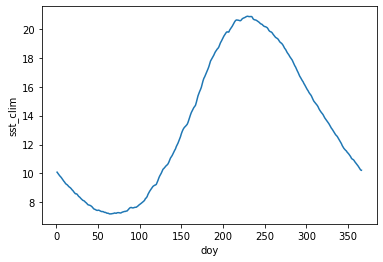

In [8]:
# Limits to climatology years:
clim_start = 1991
clim_end = 2020


# Run Calculations to create the thresholds
ref_thresholds = calc_ref_thresholds(
    x = gom_sst, 
    start_year = clim_start, 
    end_year = clim_end, 
    mhw_pct = 0.9, 
    clim_idx = "doy")

# For comparing against rolling average:
ref_thresholds.sst_clim.mean(("lon", "lat")).plot()

# 2. Smooth the Daily Climatology with Rolling Average

The code for the heatwaveR package using a moving window to smooth out the climatological mean and the marine heatwave/coldspell thresholds. The size of that window is 5 days both before and after the day of the year. This should be implemented for each pixel to smooth out the daily trend in sst/thresholds.


### Rolling Average with Annual Cycle Preserved

The following code adds the last days of the year as a lead in to the seasonal cycle and the first days of the year as a fade out. This gives the rolling window data to use for connecting the ends of the seasonal cycle.

In [9]:
# Apply a rolling average to climat reference thresholds
def smooth_clim(x, clim_idx = "doy", window_len = 6, center = True, min_periods = 1):

    # Length of the array to append to
    array_len = x[clim_idx].shape[0]

    # Days to place in the front
    head_buffer = x.sel(doy = slice(array_len - window_len, array_len))
    head_buffer = head_buffer.assign_coords({"doy" : head_buffer.coords[clim_idx] - array_len})

    # # These days will append to the end:
    tail_buffer = x.sel(doy = slice(0, window_len))
    tail_buffer = tail_buffer.assign_coords({"doy" : tail_buffer.coords[clim_idx] + array_len})

    # Combine & Check them
    roll_rdy = xr.concat([head_buffer, x,  tail_buffer], dim = "doy")

    # Perform rolling average
    x_rolled = roll_rdy.rolling(doy = window_len, center = center, min_periods = min_periods).mean()

    # take off the header
    x_rolled = x_rolled.sel(doy = slice(1, 366))

    return x_rolled

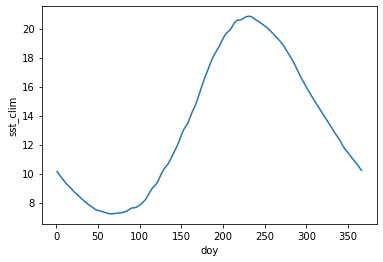

In [10]:
# plot to show results
ref_rolled = smooth_clim(x = ref_thresholds, clim_idx = "doy", window_len = 6)
ref_rolled.sst_clim.mean(("lon", "lat")).plot()

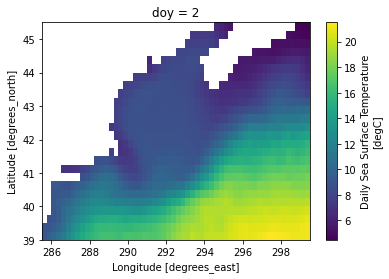

In [14]:
# # # What do the thresholds look like on a map?
ref_rolled.isel(doy = 1).hw_thresh.plot()

# 3. Get Extreme Events from Thresholds
Compare SST values against the reference period thresholds to identify extreme events.

In [15]:
# Define a function to: 
# 1. match trend residuals to the climatological mean & thresholds for each day
# 2. Flag when those new values exceed thresholds for extreme events

def detect_extreme_events(sst_ds, threshold_ds, test_var = "sst", clim_idx = "doy", thresh_high = "hw_thresh", thresh_low = "cs_thresh"):
    """
    detrend_ds: xr.dataset containing de-trended temperatures or some other variable
    threshold_ds: xr.dataset containing the climatological mean and extreme event thresholds for some reference period
    """

    # pull the climatology slice that matches the day of the year
    threshold_match = threshold_ds.sel(doy = sst_ds[clim_idx])

    # # Compare if they are over the threshold or no, event flagging
    sst_ds["is_hw"] = getattr(sst_ds, test_var) > getattr(threshold_match, thresh_high)
    sst_ds["is_cs"] = getattr(sst_ds, test_var) < getattr(threshold_match, thresh_low)

    return sst_ds.drop("doy")

In [16]:
# Plot the detrended sst + climatological mean
events_ds = gom_sst.groupby("time").map(
    detect_extreme_events, 
    threshold_ds = ref_rolled, 
    test_var = "sst", 
    thresh_high = "hw_thresh", 
    thresh_low = "cs_thresh")
events_ds

<xarray.Dataset>
Dimensions:  (time: 14975, lat: 26, lon: 56)
Coordinates:
  * time     (time) datetime64[ns] 1982-01-01 1982-01-02 ... 2022-12-31T12:00:00
  * lat      (lat) float32 39.12 39.38 39.62 39.88 ... 44.62 44.88 45.12 45.38
  * lon      (lon) float32 285.6 285.9 286.1 286.4 ... 298.6 298.9 299.1 299.4
    doy      (time) int64 1 2 3 4 5 6 7 8 9 ... 358 359 360 361 362 363 364 365
Data variables:
    sst      (time, lat, lon) float32 7.53 8.1 8.73 9.45 ... nan 4.93 4.87 5.08
    is_hw    (time, lat, lon) bool False False False False ... True True True
    is_cs    (time, lat, lon) bool False False False False ... False False False
Attributes:
    Conventions:    CF-1.5
    title:          NOAA High-resolution Blended Analysis: Daily Values using...
    institution:    NOAA/NCDC
    source:         NOAA/NCDC  ftp://eclipse.ncdc.noaa.gov/pub/OI-daily-v2/
    comment:        Reynolds, et al., 2007: Daily High-Resolution-Blended Ana...
    history:        Thu Aug 24 13:35:47 2017: ncatted -O -a References,global...
    references:     https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oiss...
    dataset_title:  NOAA Daily Optimum Interpolation Sea Surface Temperature

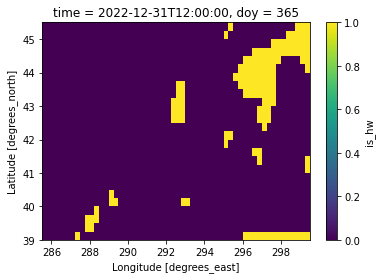

In [17]:
# Plot what a day of hw events looks like
events_ds.isel(time = -1).is_hw.plot()

In [18]:
# Save the MHW threshold

# Save it out to use offline and in R:
events_ds.to_netcdf(f"{box_root}/RES_Data/OISST/oisst_mainstays/mhw_thresholds/1991to2020_mhw_events.nc")